# Color Transfer Calculator

This notebook is used to extract the color checker patches from the digital and film images, and use the extracted patch RGB values to calculate color transfer functions from the digital RAW image to the scanned film image colors. This also implies an intermediate data linearization step for the scanned film data.

Note: This notebook relies on matplotlib widgets to provide a UI interface for user-guided color checker patch extraction.
Matplotlib widgets can sometimes be finicky and may require a second plot reload

In [1]:
%load_ext autoreload
%autoreload 2
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from colorchecker import ColorChecker, ColorCheckerReading
from digitalimage import DigitalImage

## TE226 Color checker
We start off by building a simple color tranfer function from photos of a TE226 Color checker backlit with a lamp of unknown illuminant characteristic

### Step 1. Model Color Checker

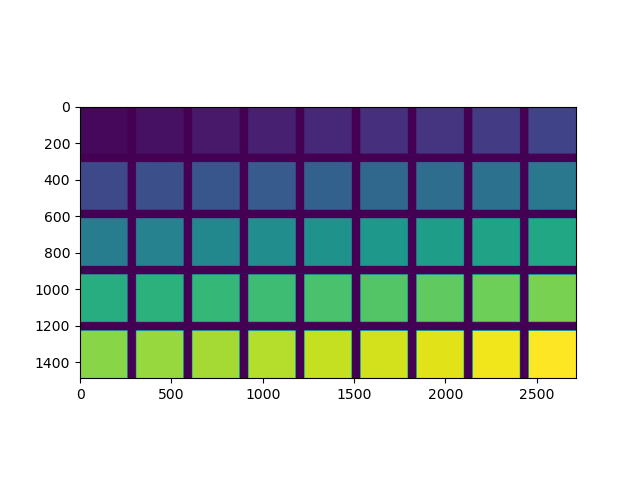

In [2]:
# borders are larger than the real color checker to build a margin to the edges of color patches
TE226 = ColorChecker(5, 9, 260, 47)
fig_checker = plt.figure()
plt.imshow(TE226.np_array)

### Step 2. Import digital image patches

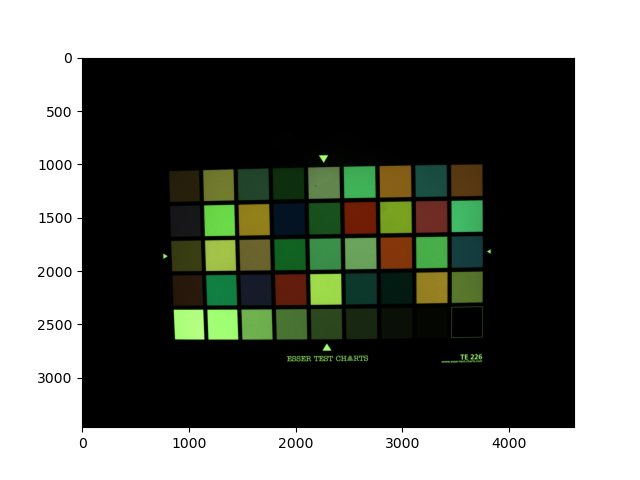

In [3]:
# exposure is corrected as the scanned image is more expose,
# and we don't want the calculated color transfer function to increase exposure too much
g81_img = DigitalImage("dataset\digital\P1480487.RW2", exposure=2)
plt.figure()
plt.imshow(g81_img.raw)

Output()

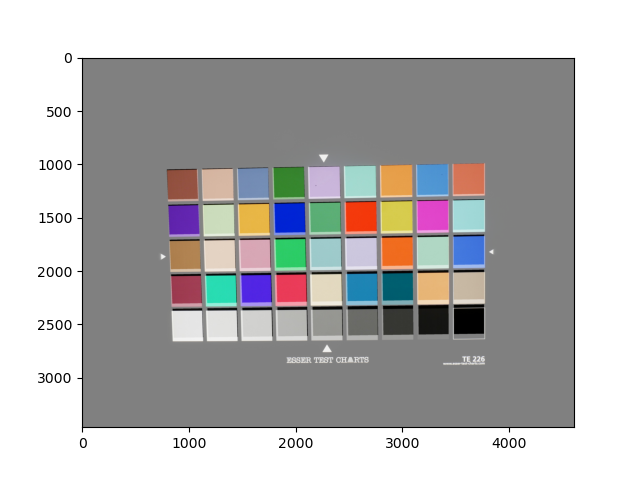

In [4]:
# select color checker location with UI interface. Reading is preloaded for ease of use if found in local files
# you can enlarge the matplotlib widget with the bottom right corner to make the color checker identification easier
path_TE226_G81_reading = "color_transfer_data/patches/TE226_G81.ccr"
TE226_g81_reading = ColorCheckerReading.load(path_TE226_G81_reading, g81_img.raw) if Path(path_TE226_G81_reading).is_file() else ColorCheckerReading(TE226, g81_img.raw)
TE226_g81_reading.locate_color_checker(g81_img.thumbnail)

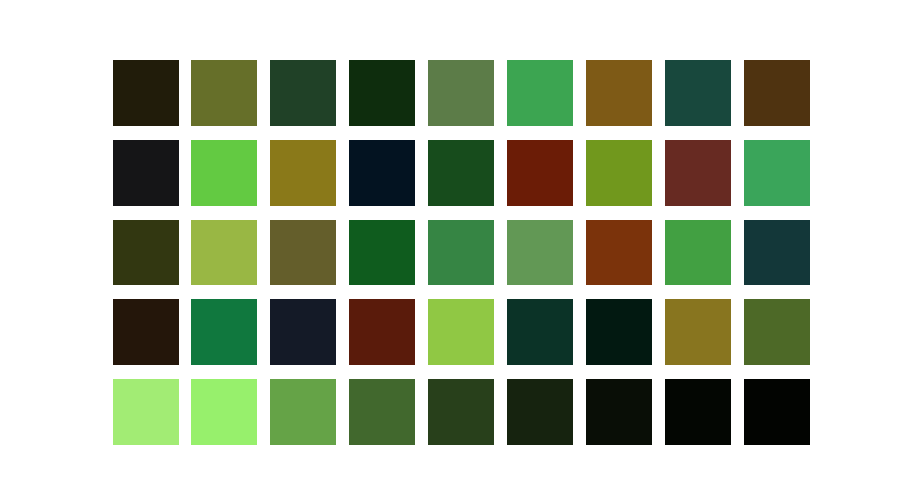

In [8]:
# check the reading
TE226_g81_reading.plot_patches()

In [6]:
# Once you are happy with the reading, you can save it so you don't have to calculate it next time
TE226_g81_reading.save(path_TE226_G81_reading)